# Web Scraper for Systematic Reviews

### Pre-run checks (Allways run before anything else)

In [2]:
import prerunchecks

prerunchecks.check_network()

External IP is 193.136.62.5, which belongs to the range assigned to IPP (193.136.56.0/21)


## Metadata Scraper

## Data Cleaner

In [2]:
from datacleaner import DataCleaner

cleaner = DataCleaner()

# This will be handled by metadata scraper 
data_files_path = ['testdata/no-title.ris', 'testdata/artf-intl-wos.ris']

for file in data_files_path:
    cleaner.add_file(file)
    
print('Added all files')
print(f'Total number of articles imported: {cleaner.count_in_entries()}')

Added all files
Total number of articles imported: 159


In [3]:
n_dup, n_no_title, n_no_abst = cleaner.clean_entries()

print(f'Number of duplicated entries: {n_dup}')
print(f'Number of entries without title: {n_no_title}')
print(f'Number of entries without abstract: {n_no_abst}')
print(f'Number of entries after cleanup: {cleaner.count_out_entries()}')

138
Number of duplicated entries: 3
Number of entries without title: 1
Number of entries without abstract: 17
Number of entries after cleanup: 138


<Axes: title={'center': 'Data Split after Cleanup'}>

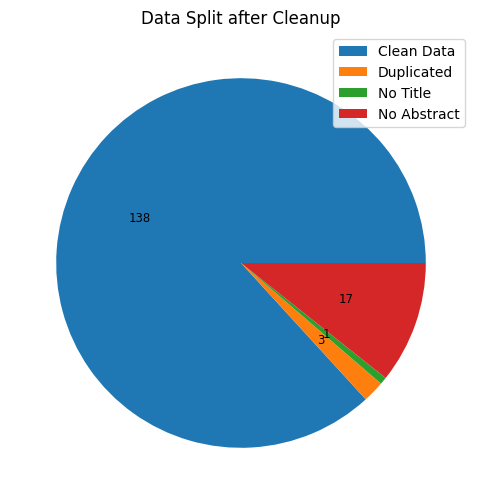

In [22]:
from pandas import Series

ser = Series([cleaner.count_out_entries(), n_dup, n_no_title, n_no_abst], index=['Clean Data', 'Duplicated', 'No Title', 'No Abstract'])

ser.plot(kind='pie', title='Data Split after Cleanup', figsize=(6,6), 
         fontsize='small', autopct=lambda x: '{:.0f}'.format(x * ser.sum() / 100), 
         labels=None, legend=True)

## PDF Scraper